# Models for Multi-class classfication

## Import libs and read data

In [1]:
import numpy as np
import pandas as pd 
# import matplotlib as mpl   
import matplotlib.pyplot as plt
# import seaborn as sns
# from scipy.signal import find_peaks, savgol_filter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from keras.optimizers import Adam
from keras import layers, models
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, LeakyReLU, BatchNormalization, MaxPooling1D, Dropout
from keras.utils import to_categorical
import glob

In [2]:
data = pd.read_csv("../input/data.csv")

In [3]:
display(data.head().T, data.shape)

,0,1,2,3,4
320,-1.388896,16.722093,0.329687,-10.598846,10.015236
321,0.05821,-1.186429,-0.747993,-5.978379,12.575455
322,5.898464,-10.186022,-1.588051,1.822014,13.012607
323,5.849397,-3.832706,0.152671,12.90642,13.932454
324,2.37903,12.73007,5.357345,21.049637,13.677982
...,...,...,...,...,...
1648,1.384356,-4.633642,-5.380405,10.001486,35.561525
1649,16.59277,-6.431111,-6.852814,1.22302,37.348663
1650,8.760738,25.847542,-2.682321,1.914469,11.53166
Diagnostic,Streptavidin,Streptavidin,Streptavidin,S,S


(35, 1333)

## Data prep

In [4]:
def data_preprocessing(data):

    X = data.drop(['Diagnostic', 'COVID-19_Status'], axis=1)
    X.columns = X.columns.astype(int)
    y = data['Diagnostic'].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    label_encoder = OneHotEncoder(sparse_output=False)
    y_train_encoded = label_encoder.fit_transform(y_train.reshape(-1, 1))
    y_test_encoded = label_encoder.transform(y_test.reshape(-1, 1))

    return X_train, X_test, y_train_encoded, y_test_encoded

In [ ]:
from keras import backend as K

def focal_loss(gamma=2.0, alpha=0.25):
    def _focal_loss(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_factor = 1.0
        modulating_factor = K.pow(1.0 - p_t, gamma)
        loss = -alpha * alpha_factor * modulating_factor * K.log(K.clip(y_pred, epsilon, 1.0 - epsilon))
        return K.mean(loss, axis=-1)
    
    return _focal_loss

## Simple NN

Test Loss: 9.23% - Test Accuracy: 28.57%
Test Loss: 9.50% - Test Accuracy: 28.57%
Test Loss: 10.21% - Test Accuracy: 28.57%
Test Loss: 10.28% - Test Accuracy: 42.86%
Test Loss: 10.38% - Test Accuracy: 28.57%
Test Loss: 10.40% - Test Accuracy: 14.29%
Test Loss: 10.08% - Test Accuracy: 28.57%
Test Loss: 10.53% - Test Accuracy: 28.57%
Test Loss: 10.90% - Test Accuracy: 28.57%
Test Loss: 10.93% - Test Accuracy: 28.57%
Test Loss: 10.76% - Test Accuracy: 42.86%
Test Loss: 10.85% - Test Accuracy: 28.57%
Test Loss: 10.77% - Test Accuracy: 28.57%
Test Loss: 10.71% - Test Accuracy: 28.57%
Test Loss: 10.81% - Test Accuracy: 28.57%
Test Loss: 10.77% - Test Accuracy: 28.57%
Test Loss: 10.95% - Test Accuracy: 28.57%
Test Loss: 11.29% - Test Accuracy: 28.57%
Test Loss: 10.96% - Test Accuracy: 28.57%
Test Loss: 10.27% - Test Accuracy: 28.57%
Test Loss: 10.12% - Test Accuracy: 28.57%
Test Loss: 9.99% - Test Accuracy: 28.57%
Test Loss: 9.58% - Test Accuracy: 28.57%
Test Loss: 9.07% - Test Accuracy: 28.5

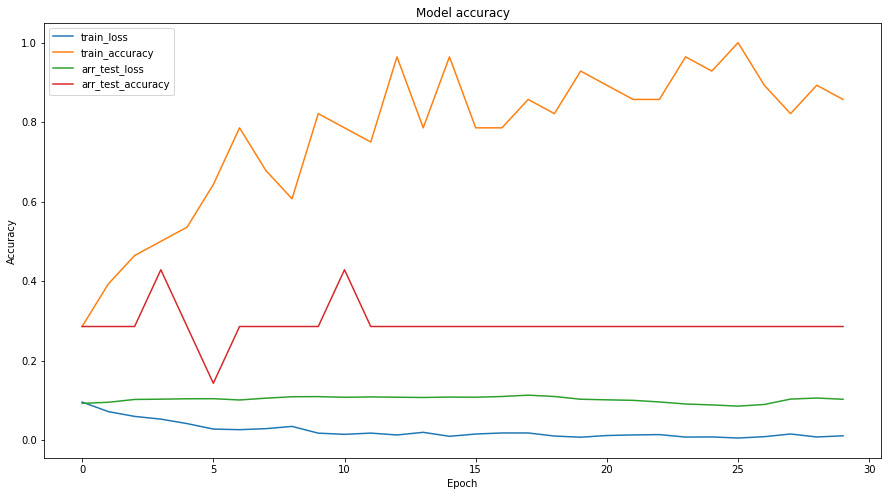

In [80]:
def simple_nn(data):

    X_train, X_test, y_train, y_test = data_preprocessing(data)

    num_classes = y_train.shape[1]
    num_features = X_train.shape[1]

    model = Sequential([
    Dense(2048, activation='relu', input_shape=(num_features,)),

    Dense(1024, activation='ReLU'),
    BatchNormalization(),

    Dense(1024, activation='ReLU'),
    BatchNormalization(),

    Dense(1024, activation='ReLU'),
    BatchNormalization(),

    Dense(512, activation='ReLU'),
    BatchNormalization(),
    # Dropout(0.5),

    Dense(128, activation='ReLU'),
    BatchNormalization(),

    Dense(64, activation='tanh'),
    BatchNormalization(),
    Dense(num_classes, activation='softmax')
])

    optimizer = Adam(learning_rate=0.0001)
    # Compile the model
    model.compile(optimizer=optimizer, loss=focal_loss(2, 0.25), metrics=['accuracy'])

    train_loss = []
    train_accuracy = []
    arr_test_loss = []
    arr_test_accuracy = []
    for i in range(30):
        history = model.fit(X_train, y_train, epochs=1, batch_size=8, verbose=0)
        
        train_loss.append(history.history['loss'][0])
        train_accuracy.append(history.history['accuracy'][0])

        test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

        arr_test_loss.append(test_loss)
        arr_test_accuracy.append(test_accuracy)
        print(f'Test Loss: {test_loss*100:.2f}% - Test Accuracy: {test_accuracy*100:.2f}%')

    plt.figure(figsize=(15, 8))
    plt.plot(train_loss, label='train_loss')
    plt.plot(train_accuracy, label='train_accuracy')
    plt.plot(arr_test_loss, label='arr_test_loss')
    plt.plot(arr_test_accuracy, label='arr_test_accuracy')
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    plt.show() 

    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    # print(f'Test loss: {loss:.2f}, Test accuracy: {accuracy*100:.2f}%')

    return model

simple_model = simple_nn(data)

In [19]:
simple_model = simple_nn(data)

Epoch 1/10
28/28 [==============================] - 2s 46ms/step - loss: 1.6042 - accuracy: 0.1786
Epoch 2/10
28/28 [==============================] - 1s 45ms/step - loss: 1.5496 - accuracy: 0.3214
Epoch 3/10
28/28 [==============================] - 1s 45ms/step - loss: 1.5126 - accuracy: 0.3214
Epoch 4/10
28/28 [==============================] - 1s 45ms/step - loss: 1.5130 - accuracy: 0.3214
Epoch 5/10
28/28 [==============================] - 1s 45ms/step - loss: 1.4949 - accuracy: 0.3214
Epoch 6/10
28/28 [==============================] - 1s 46ms/step - loss: 1.5040 - accuracy: 0.3214
Epoch 7/10
28/28 [==============================] - 1s 46ms/step - loss: 1.5080 - accuracy: 0.3214
Epoch 8/10
28/28 [==============================] - 1s 46ms/step - loss: 1.4999 - accuracy: 0.3214
Epoch 9/10
28/28 [==============================] - 1s 44ms/step - loss: 1.5021 - accuracy: 0.3214
Epoch 10/10
28/28 [==============================] - 1s 44ms/step - loss: 1.5104 - accuracy: 0.3214
Test loss

## LeNet architecture CNN model

In [38]:
import matplotlib.pyplot as plt
from keras.optimizers import Adam

In [43]:
from keras import backend as K

def focal_loss(gamma=2.0, alpha=0.25):
    def _focal_loss(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_factor = 1.0
        modulating_factor = K.pow(1.0 - p_t, gamma)
        loss = -alpha * alpha_factor * modulating_factor * K.log(K.clip(y_pred, epsilon, 1.0 - epsilon))
        return K.mean(loss, axis=-1)
    
    return _focal_loss

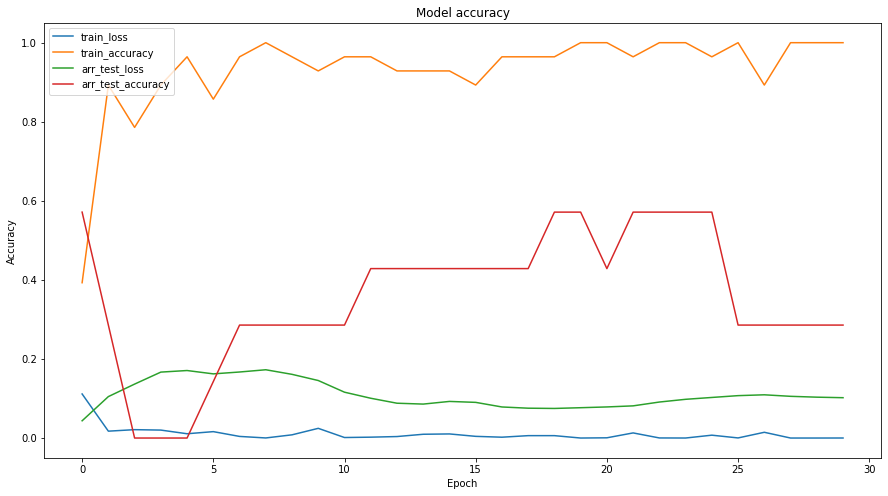

In [76]:
def leNet1D(data):
    
    X_train, X_test, y_train, y_test = data_preprocessing(data)

    num_features = X_train.shape[1]
    num_classes = y_train.shape[1]

    lenet = Sequential()
    
    # First Layer
    lenet.add(Conv1D(16, 21, input_shape=(num_features, 1)))
    lenet.add(BatchNormalization())
    lenet.add(LeakyReLU())
    lenet.add(MaxPooling1D(2))

    # Second Layer
    lenet.add(Conv1D(32, 11))
    lenet.add(BatchNormalization())
    lenet.add(LeakyReLU())
    lenet.add(MaxPooling1D(2))

    # # Third Layer
    # lenet.add(Conv1D(64, 5))
    # lenet.add(BatchNormalization())
    # lenet.add(LeakyReLU())
    # lenet.add(MaxPooling1D(2))

    # 4th Layer: Concatenate and Flatten
    lenet.add(Flatten())

    # 5th Layer: Dense Layers
    lenet.add(Dense(2048, activation='tanh'))
    lenet.add(BatchNormalization())
    lenet.add(Dropout(0.5))

    # 6th Layer: Output Layer
    lenet.add(Dense(num_classes, activation='softmax'))

    optimizer = Adam(learning_rate=0.0001)
    # Compile the model
    lenet.compile(optimizer=optimizer, loss=focal_loss(2, 0.25), metrics=['accuracy'])

    train_loss = []
    train_accuracy = []
    arr_test_loss = []
    arr_test_accuracy = []
    for i in range(30):
        history = lenet.fit(X_train, y_train, epochs=1, batch_size=8, verbose=0)
        
        train_loss.append(history.history['loss'][0])
        train_accuracy.append(history.history['accuracy'][0])

        test_loss, test_accuracy = lenet.evaluate(X_test, y_test, verbose=0)

        arr_test_loss.append(test_loss)
        arr_test_accuracy.append(test_accuracy)
        print(f'Test Loss: {test_loss*100:.2f}% - Test Accuracy: {test_accuracy*100:.2f}%')

    plt.figure(figsize=(15, 8))
    plt.plot(train_loss, label='train_loss')
    plt.plot(train_accuracy, label='train_accuracy')
    plt.plot(arr_test_loss, label='arr_test_loss')
    plt.plot(arr_test_accuracy, label='arr_test_accuracy')
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    plt.show() 
    # print(f'Test Loss: {test_loss*100:.2f}% - Test Accuracy: {test_accuracy*100:.2f}%')

    return lenet

raman_spectral_leNet_model = leNet1D(data)

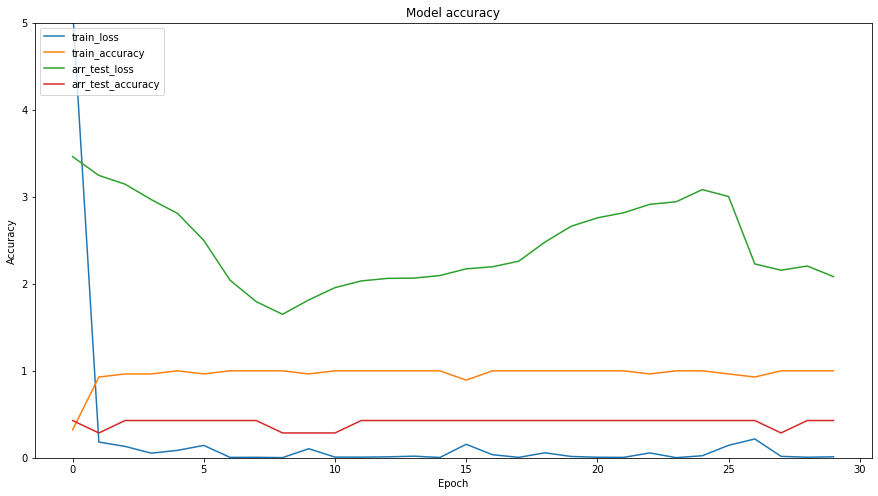

In [74]:
def leNet1D(data):
    
    X_train, X_test, y_train, y_test = data_preprocessing(data)

    num_features = X_train.shape[1]
    num_classes = y_train.shape[1]

    lenet = Sequential()
    
    # First Layer
    lenet.add(Conv1D(16, 21, input_shape=(num_features, 1)))
    lenet.add(BatchNormalization())
    lenet.add(LeakyReLU())
    lenet.add(MaxPooling1D(2))

    # Second Layer
    lenet.add(Conv1D(32, 11))
    lenet.add(BatchNormalization())
    lenet.add(LeakyReLU())
    lenet.add(MaxPooling1D(2))

    # # Third Layer
    # lenet.add(Conv1D(64, 5))
    # lenet.add(BatchNormalization())
    # lenet.add(LeakyReLU())
    # lenet.add(MaxPooling1D(2))

    # 4th Layer: Concatenate and Flatten
    lenet.add(Flatten())

    # 5th Layer: Dense Layers
    lenet.add(Dense(2048, activation='tanh'))
    lenet.add(BatchNormalization())
    lenet.add(Dropout(0.5))

    # 6th Layer: Output Layer
    lenet.add(Dense(num_classes, activation='softmax'))

    optimizer = Adam(learning_rate=0.001)
    # Compile the model
    lenet.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    train_loss = []
    train_accuracy = []
    arr_test_loss = []
    arr_test_accuracy = []
    for i in range(30):
        history = lenet.fit(X_train, y_train, epochs=1, batch_size=8, verbose=0)
        
        train_loss.append(history.history['loss'][0])
        train_accuracy.append(history.history['accuracy'][0])

        test_loss, test_accuracy = lenet.evaluate(X_test, y_test, verbose=0)

        arr_test_loss.append(test_loss)
        arr_test_accuracy.append(test_accuracy)

    plt.figure(figsize=(15, 8))
    plt.plot(train_loss, label='train_loss')
    plt.plot(train_accuracy, label='train_accuracy')
    plt.plot(arr_test_loss, label='arr_test_loss')
    plt.plot(arr_test_accuracy, label='arr_test_accuracy')
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    plt.ylim(0, 5)
    plt.show() 
    # print(f'Test Loss: {test_loss*100:.2f}% - Test Accuracy: {test_accuracy*100:.2f}%')

    return lenet

raman_spectral_leNet_model = leNet1D(data)

Test Loss: 20.74% - Test Accuracy: 28.57%
Test Loss: 17.23% - Test Accuracy: 28.57%
Test Loss: 13.86% - Test Accuracy: 42.86%
Test Loss: 11.67% - Test Accuracy: 42.86%
Test Loss: 10.49% - Test Accuracy: 42.86%
Test Loss: 8.35% - Test Accuracy: 42.86%
Test Loss: 8.67% - Test Accuracy: 42.86%
Test Loss: 8.80% - Test Accuracy: 42.86%
Test Loss: 8.70% - Test Accuracy: 42.86%
Test Loss: 8.92% - Test Accuracy: 28.57%
Test Loss: 9.35% - Test Accuracy: 28.57%
Test Loss: 9.68% - Test Accuracy: 28.57%
Test Loss: 10.02% - Test Accuracy: 28.57%
Test Loss: 10.06% - Test Accuracy: 28.57%
Test Loss: 9.83% - Test Accuracy: 28.57%
Test Loss: 9.12% - Test Accuracy: 28.57%
Test Loss: 8.02% - Test Accuracy: 28.57%
Test Loss: 7.16% - Test Accuracy: 28.57%
Test Loss: 6.54% - Test Accuracy: 28.57%
Test Loss: 6.30% - Test Accuracy: 42.86%
Test Loss: 6.50% - Test Accuracy: 42.86%
Test Loss: 6.45% - Test Accuracy: 42.86%
Test Loss: 6.28% - Test Accuracy: 42.86%
Test Loss: 6.16% - Test Accuracy: 42.86%
Test Loss

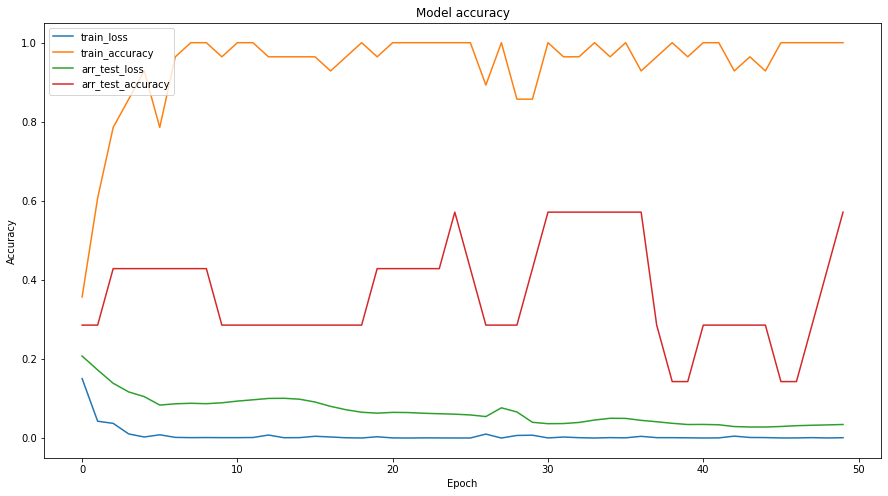

In [70]:
def leNet1D(data):
    
    X_train, X_test, y_train, y_test = data_preprocessing(data)

    num_features = X_train.shape[1]
    num_classes = y_train.shape[1]

    lenet = Sequential()
    
    # First Layer
    lenet.add(Conv1D(16, 21, input_shape=(num_features, 1)))
    lenet.add(BatchNormalization())
    lenet.add(LeakyReLU())
    lenet.add(MaxPooling1D(2))

    # Second Layer
    lenet.add(Conv1D(32, 11))
    lenet.add(BatchNormalization())
    lenet.add(LeakyReLU())
    lenet.add(MaxPooling1D(2))

    # 4th Layer: Concatenate and Flatten
    lenet.add(Flatten())

    # 5th Layer: Dense Layers
    lenet.add(Dense(512, activation='tanh'))
    lenet.add(BatchNormalization())
    lenet.add(Dropout(0.5))

    # 6th Layer: Output Layer
    lenet.add(Dense(num_classes, activation='softmax'))

    optimizer = Adam(learning_rate=0.0005)
    # Compile the model
    lenet.compile(optimizer=optimizer, loss=focal_loss(3, 0.25), metrics=['accuracy'])

    train_loss = []
    train_accuracy = []
    arr_test_loss = []
    arr_test_accuracy = []
    for i in range(50):
        history = lenet.fit(X_train, y_train, epochs=1, batch_size=8, verbose=0)
        
        train_loss.append(history.history['loss'][0])
        train_accuracy.append(history.history['accuracy'][0])

        test_loss, test_accuracy = lenet.evaluate(X_test, y_test, verbose=0)

        arr_test_loss.append(test_loss)
        arr_test_accuracy.append(test_accuracy)
        print(f'Test Loss: {test_loss*100:.2f}% - Test Accuracy: {test_accuracy*100:.2f}%')

    plt.figure(figsize=(15, 8))
    plt.plot(train_loss, label='train_loss')
    plt.plot(train_accuracy, label='train_accuracy')
    plt.plot(arr_test_loss, label='arr_test_loss')
    plt.plot(arr_test_accuracy, label='arr_test_accuracy')
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    plt.show() 
    # print(f'Test Loss: {test_loss*100:.2f}% - Test Accuracy: {test_accuracy*100:.2f}%')

    return lenet

raman_spectral_leNet_model = leNet1D(data)

In [59]:
def weighted_binary_crossentropy(pos_weight):
    def _weighted_binary_crossentropy(y_true, y_pred):
        # Ensure that binary crossentropy is used
        y_true = K.clip(y_true, K.epsilon(), 1 - K.epsilon())
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        logit_y_pred = K.log(y_pred / (1 - y_pred))
        loss = K.mean(pos_weight * (1 - y_true) * logit_y_pred - y_true * logit_y_pred, axis=-1)
        return loss
    
    return _weighted_binary_crossentropy

In [60]:
labels = np.array([3, 9, 9, 11, 3])

# Calculate class frequencies
positive_class_count = np.sum(labels == 3) + np.sum(labels == 11)
negative_class_count = np.sum(labels != 3) + np.sum(labels != 11)

# Calculate the class imbalance ratio
imbalance_ratio = negative_class_count / positive_class_count

# Set pos_weight
pos_weight = imbalance_ratio

test loss -17.997676849365234 test acc 28.57%
test loss -17.99697494506836 test acc 28.57%
test loss -17.996976852416992 test acc 28.57%
test loss -17.984716415405273 test acc 28.57%
test loss -18.975528717041016 test acc 28.57%
test loss -19.831771850585938 test acc 42.86%
test loss -20.023168563842773 test acc 42.86%
test loss -18.981721878051758 test acc 42.86%
test loss -18.673715591430664 test acc 42.86%
test loss -18.598663330078125 test acc 42.86%
test loss -18.222492218017578 test acc 42.86%
test loss -15.862929344177246 test acc 42.86%
test loss -15.388521194458008 test acc 28.57%
test loss -13.908645629882812 test acc 28.57%
test loss -13.658951759338379 test acc 28.57%
test loss -15.28441047668457 test acc 42.86%
test loss -14.49040699005127 test acc 28.57%
test loss -13.366730690002441 test acc 28.57%
test loss -12.21347713470459 test acc 42.86%
test loss -11.375645637512207 test acc 42.86%
test loss -13.662248611450195 test acc 42.86%
test loss -13.74074649810791 test acc 

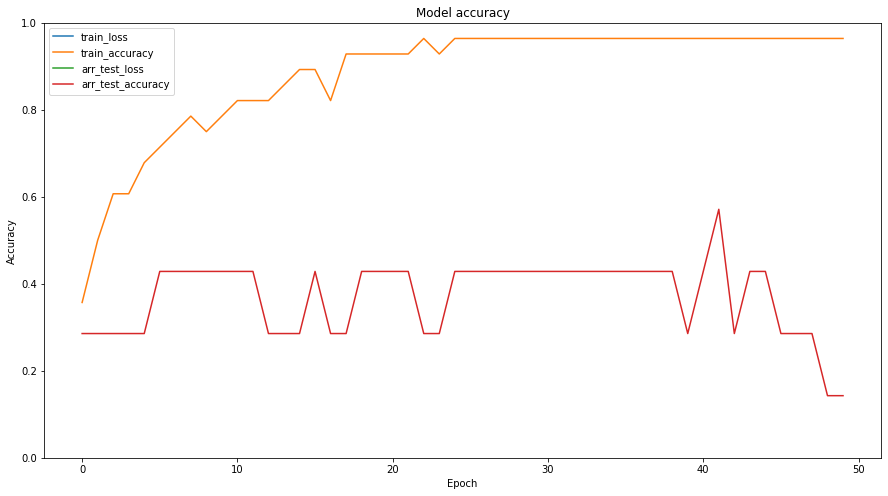

In [69]:
def leNet1D(data):
    
    X_train, X_test, y_train, y_test = data_preprocessing(data)

    num_features = X_train.shape[1]
    num_classes = y_train.shape[1]

    lenet = Sequential()
    
    # First Layer
    lenet.add(Conv1D(16, 21, input_shape=(num_features, 1)))
    lenet.add(BatchNormalization())
    lenet.add(LeakyReLU())
    lenet.add(MaxPooling1D(2))

    # Second Layer
    lenet.add(Conv1D(32, 11))
    lenet.add(BatchNormalization())
    lenet.add(LeakyReLU())
    lenet.add(MaxPooling1D(2))

    # Second Layer
    lenet.add(Conv1D(64, 5))
    lenet.add(BatchNormalization())
    lenet.add(LeakyReLU())
    lenet.add(MaxPooling1D(2))

    # 4th Layer: Concatenate and Flatten
    lenet.add(Flatten())

    # 5th Layer: Dense Layers
    lenet.add(Dense(2048, activation='tanh'))
    lenet.add(BatchNormalization())
    lenet.add(Dropout(0.5))

    # 6th Layer: Output Layer
    lenet.add(Dense(num_classes, activation='softmax'))

    optimizer = Adam(learning_rate=0.001)
    # Compile the model
    lenet.compile(optimizer=optimizer, loss=weighted_binary_crossentropy(pos_weight), metrics=['accuracy'])

    train_loss = []
    train_accuracy = []
    arr_test_loss = []
    arr_test_accuracy = []
    for i in range(50):
        history = lenet.fit(X_train, y_train, epochs=1, batch_size=8, verbose=0)
        
        train_loss.append(history.history['loss'][0])
        train_accuracy.append(history.history['accuracy'][0])

        test_loss, test_accuracy = lenet.evaluate(X_test, y_test, verbose=0)

        arr_test_loss.append(test_loss)
        arr_test_accuracy.append(test_accuracy)
        print(f'test loss {test_loss:.2f} test acc {test_accuracy*100:.2f}%')

    plt.figure(figsize=(15, 8))
    plt.plot(train_loss, label='train_loss')
    plt.plot(train_accuracy, label='train_accuracy')
    plt.plot(arr_test_loss, label='arr_test_loss')
    plt.plot(arr_test_accuracy, label='arr_test_accuracy')
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    plt.ylim(0, 1)
    plt.show() 
    # print(f'Test Loss: {test_loss*100:.2f}% - Test Accuracy: {test_accuracy*100:.2f}%')

    return lenet

raman_spectral_leNet_model = leNet1D(data)

## Report